## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 5
BATCH_SIZE = [2, 16, 32, 128]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for i, (use_preact, bz) in enumerate(itertools.product(PRE_ACTIVATE, BATCH_SIZE)):
    print("Numbers of exp: %i, use_preact: %s, batch_size: %i" % (i, use_preact, bz))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=use_preact)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bz, 
              validation_data=(x_test, y_test), 
              verbose=0,
              shuffle=True)
    
    # Collect results
    #exp_name_tag = ("exp-%s" % (i))
    exp_name_tag = "exp-PRE_ACTIVATE-%s-BATCH_SIZE-%s" % (str(use_preact), str(bz))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activati

Numbers of exp: 5, use_preact: False, batch_size: 16
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
_________________________________________________________________
batch_

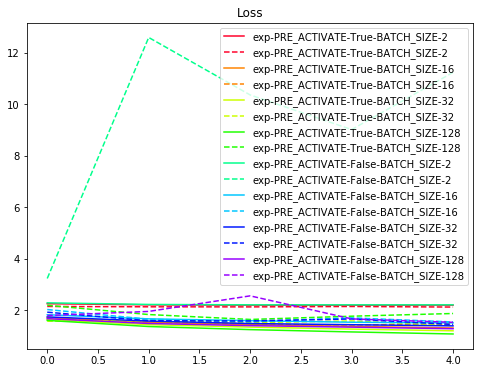

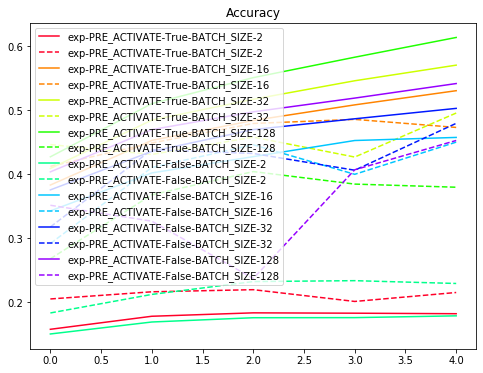

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()